In [1]:
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# Testing

In [2]:
ts_101 = np.load('/home/despoB/dlurie/Projects/despolab_lesion/derivatives/sub-101/func/sub-101_task-rest_acq-128px_run-01_bold_space-T1w_timeseries_atlas-BNA_motion24.npy')

In [3]:
ts_101.shape

(300, 246)

In [4]:
roi_list = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/analysis/first_pass_ROIs.txt', dtype='int')

In [5]:
roi_list = roi_list[1:]

In [6]:
roi_list.shape

(207,)

In [7]:
roi_ids = [i-1 for i in roi_list]

In [8]:
ts_101[:,roi_ids].shape

(300, 207)

$$
V(t) = \frac{1}{N}  \sum_{i=1}^{N} \left | S_{i}(t) - \bar{S}(t) \right |
$$

- *V* is the spatial coherence of a group of *N* regions at time *t*.
- $S_{i}$ is the signal for an individual region.
- $\bar{S}$ is the "mean of all considered time courses".

In [9]:
def hellyer_V(signals):
    sbar = np.mean(signals)
    diffs = []
    for si in signals:
        diffs.append(np.absolute(si-sbar))
    sigma = np.sum(diffs)
    V = 1/len(signals) * sigma
    return V

In [10]:
hellyer_V(ts_101[1, roi_ids])

2.0154556453206909

In [11]:
all_v = []
for vol in ts_101:
    all_v.append(hellyer_V(vol))

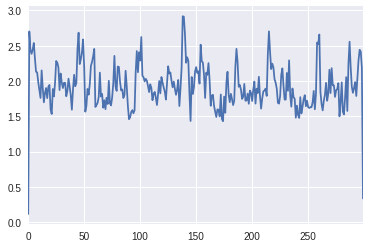

In [12]:
sns.tsplot(np.std(ts_101, axis=1))

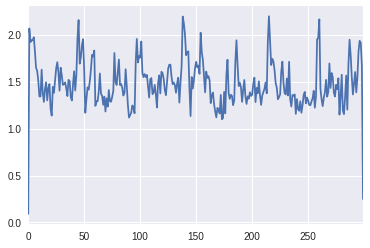

In [13]:
sns.tsplot(all_v)

In [14]:
def metastability(timeseries):
    all_v = []
    for vol in timeseries:
        all_v.append(hellyer_V(vol))
    ms = np.std(np.array(all_v[1:-1])) # drop the first and last timepoint due to filter issues
    return ms

In [15]:
metastability(ts_101[:, roi_ids])

0.23728563278030707

# Run for patients

In [16]:
skip = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/analysis/first_pass_skips.txt', dtype='int')

In [17]:
skip = [str(i) for i in skip]

In [42]:
ms_data = []
for acq in ['128px','64px']:
    # Load list of subjects with the specified EPI sequence.
    sublist_file = '/home/despoB/dlurie/Projects/despolab_lesion/derivatives/has_acq-{0}.txt'.format(acq)
    subject_list = np.loadtxt(sublist_file, dtype='int')
    subject_list = [str(i) for i in subject_list]
    
    ts_fpt = '/home/despoB/dlurie/Projects/despolab_lesion/derivatives/sub-{0}/func/sub-{0}_task-rest_acq-{1}_run-01_bold_space-T1w_timeseries_atlas-BNA_motion24.npy'
    
    for pid in subject_list:
        if pid not in skip:
            ts = np.load(ts_fpt.format(pid, acq))
            ms = metastability(ts[:,roi_ids])
            ms_data.append((pid, ms))

In [43]:
import pandas as pd

In [44]:
ms_df = pd.DataFrame.from_records(ms_data, columns=['pid', 'metastability'])

In [45]:
ms_df.to_csv('/home/despoB/dlurie/Projects/despolab_lesion/analysis/ms.csv', index=False)